In [1334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso # We use LASSO for regression 
from sklearn.decomposition import PCA #USE PCA FOR PCR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime
import math
import tslib


In [1335]:
# Link for NFL Attendance Data: https://docs.google.com/spreadsheets/d/1DRMB5FLC3tdngeurDwps1CS8-6smEZvmq5R-ghjEv5k/edit#gid=0


#Import NFL Attendance Data using Pandas
attendance_df = pd.read_csv('NFL_Data.csv')

#Lots of NaN values, remove values without 'Team'
attendance_df = attendance_df.loc[~attendance_df['Team'].isnull()]

#Import NFL stadium County data, along with Neutral Counties
stadium_county_df = pd.read_csv('Stadium_County.csv',header=1) #Data is a little bit Messy 


#County Covid Rates Provided from NYTIMES Github Database, https://github.com/nytimes/covid-19-data/blob/master/us-counties-2020.csv
county_covid = pd.read_csv('County_Covid_Data.csv')


stadium_county_df['Team '].fillna(method = 'ffill', inplace= True)
county_covid['date'] = pd.to_datetime(county_covid['date'])
county_covid = county_covid.loc[~(county_covid['county'] == 'Unknown')]
county_covid = county_covid.loc[~(county_covid['cases'].isnull())]


#We want to use stadium_county_df to find buffer counties and stadium counties and neutral counties. 
stadium_county_df

,Team,First date home stadium open to fans,County(s),State,% fans,Counties,State.1,% fans.1,Unnamed: 8
0,Arizona,10/25/2020,COUNTY DATA NOT AVAILABLE,NaN,NaN,NaN,NaN,NaN,NaN
1,Atlanta,10/25/2020,Fulton,GA,18.63,Cobb,GA,8.24,"April 12, 2020: Our database changed to exclud..."
2,Atlanta,NaN,NaN,NaN,NaN,Dekalb,GA,7.84,NaN
3,Atlanta,NaN,NaN,NaN,NaN,Gwinnett,GA,7.05,NaN
4,Atlanta,NaN,NaN,NaN,NaN,Hall,GA,2.49,NaN
...,...,...,...,...,...,...,...,...,...
180,Tennessee,NaN,NaN,NaN,NaN,Warren,KY,1.23,NaN
181,Tennessee,NaN,NaN,NaN,NaN,Knox,TN,1.17,NaN
182,Tennessee,NaN,NaN,NaN,NaN,Cook,IL,1.01,NaN
183,Tennessee,NaN,NaN,NaN,NaN,Cheatham,TN,1.01,NaN


In [1336]:
#We want to fill in state/county Data for cities that don't have stadium counties listed. Go through 1 by 1

stadium_county_df.loc[stadium_county_df['Team '] == 'Arizona', 'County(s)'] = 'Maricopa'
stadium_county_df.loc[stadium_county_df['Team '] == 'Arizona', 'State'] = 'Arizona'

stadium_county_df.loc[stadium_county_df['Team '] == 'Chicago', 'County(s)'] = 'Cook'
stadium_county_df.loc[stadium_county_df['Team '] == 'Chicago', 'State'] = 'Illinois'

stadium_county_df.loc[stadium_county_df['Team '] == 'Detroit', 'County(s)'] = 'Wayne'
stadium_county_df.loc[stadium_county_df['Team '] == 'Detroit', 'State'] = 'Michigan'

stadium_county_df.loc[stadium_county_df['Team '] == 'Las Vegas', 'County(s)'] = 'Clark'
stadium_county_df.loc[stadium_county_df['Team '] == 'Las Vegas', 'State'] = 'Nevada'

stadium_county_df.loc[stadium_county_df['Team '] == 'LA Chargers', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team '] == 'LA Chargers', 'State'] = 'California'

stadium_county_df.loc[stadium_county_df['Team '] == 'LA Rams', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team '] == 'LA Rams', 'State'] = 'California'

stadium_county_df.loc[stadium_county_df['Team '] == 'Minnesota', 'County(s)'] = 'Ramsey'
stadium_county_df.loc[stadium_county_df['Team '] == 'Minnesota', 'State'] = 'Minnesota'

stadium_county_df.loc[stadium_county_df['Team '] == 'New England', 'County(s)'] = 'Norfolk'
stadium_county_df.loc[stadium_county_df['Team '] == 'New England', 'State'] = 'Massachusetts'

stadium_county_df.loc[stadium_county_df['Team '] == 'New Orleans', 'County(s)'] = 'Orleans'
stadium_county_df.loc[stadium_county_df['Team '] == 'New Orleans', 'State'] = 'Louisiana'

stadium_county_df.loc[stadium_county_df['Team '] == 'NY Giants', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team '] == 'NY Giants', 'State'] = 'New Jersey'

stadium_county_df.loc[stadium_county_df['Team '] == 'NY Jets', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team '] == 'NY Jets', 'State'] = 'New Jersey'

stadium_county_df.loc[stadium_county_df['Team '] == 'San Francisco', 'County(s)'] = 'Santa Clara'
stadium_county_df.loc[stadium_county_df['Team '] == 'San Francisco', 'State'] = 'California'

stadium_county_df.loc[stadium_county_df['Team '] == 'Seattle', 'County(s)'] = 'King'
stadium_county_df.loc[stadium_county_df['Team '] == 'Seattle', 'State'] = 'Washington'

stadium_county_df.loc[stadium_county_df['Team '] == 'Washington', 'County(s)'] = 'District of Columbia'
stadium_county_df.loc[stadium_county_df['Team '] == 'Washington', 'State'] = 'District of Columbia'

In [1337]:
home_state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [1338]:

#We want to associate NFL teams to their respective Counties. Add Column that contains 'HOME COUNTIES', and columns that contains 'NEUTRAL COUNTIES'

#attendance_df['Team City'] = attendance_df.Team.str.split().str[:-1].str.join(sep=' ') #To connect with county information


#Change exceptions with 2 name cities



def find_stadium_counties(team_city_str):
    team_city_data = stadium_county_df.loc[stadium_county_df['Team '] == team_city_str]
    team_city_data = team_city_data[team_city_data['County(s)'].notnull()]
    
    #Take away counties that don't belong in home state
    home_state = list(team_city_data['State'])[0]
    team_city_data = team_city_data[team_city_data['State.1'] == home_state]
    
    return list(set(team_city_data['County(s)']))

def find_donor_counties(team_city_str): #All counties within the state that is NOT in buffer counties.
    team_city_data = stadium_county_df.loc[stadium_county_df['Team '] == team_city_str]
    team_city_data = team_city_data[team_city_data['Counties'].notnull()]
    
    #Take away counties that don't belong in home state
    if(len(list(team_city_data['State'])) > 0): #If a home state exists... some not included in data set
        home_state = list(team_city_data['State'])[0]
    else: #Exceptions
        if team_city_str == 'Arizona':
            home_state = "AZ"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'Detroit':
            home_state = "MI"
        elif team_city_str == 'Las Vegas':
            home_state = "NV"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'LA Chargers':
            home_state = "CA"
        elif team_city_str == 'LA Rams':
            home_state = "CA"
        elif team_city_str == 'Minnesota':
            home_state = "MN"
        elif team_city_str == 'New England':
            home_state = "MA"
        elif team_city_str == 'New Orleans':
            home_state = "LA"
        elif team_city_str == 'NY Giants':
            home_state = "NY"
        elif team_city_str == 'NY Jets':
            home_state = "NJ"
        elif team_city_str == 'San Francisco':
            home_state = "CA"
        elif team_city_str == 'Seattle':
            home_state = "WA"
        elif team_city_str == 'Washington':
            home_state = "MD"
        else:
            print(team_city_str)
            home_state = ''
            
    #Home State dictionary from 2 Letters to Full Name

    
            
    team_city_data = team_city_data[team_city_data['State.1'] == home_state]
    
    buffer_counties = list(set(stadium_county_df['Counties'])) #List of neutral counties
    
    stadium_counties = list(set(stadium_county_df['County(s)'])) #List of Stadium counties
    
    
    #Run through home_state_dict, as county_covid dataset uses full names for states rather than abbreviations
    home_state = home_state_dict[home_state]
    donor_counties = county_covid.loc[(county_covid['state'] == home_state)] #All county covid for home state
    

    donor_counties = donor_counties.loc[~donor_counties['county'].isin(buffer_counties) & (~donor_counties['county'].isin(stadium_counties))]
        
    donor_counties = donor_counties[donor_counties['cases'] > 200]

    donor_counties = list(set(donor_counties['county']))
#     if home_state == 'Ohio':
#         display(sorted(donor_counties))
#         #display(donor_counties)  
            

    return donor_counties

stadium_county_df['Stadium_Counties'] = stadium_county_df['Team '].apply(find_stadium_counties)
stadium_county_df['Donor_Counties'] = stadium_county_df['Team '].apply(find_donor_counties)
    
# attendance_df['Stadium_Counties'] = attendance_df['Team City'].apply(find_stadium_counties)
# attendance_df['Donor_Counties'] = attendance_df['Team City'].apply(find_donor_counties)



In [1339]:
stadium_county_df.rename(columns={'Team ': 'Team'}, inplace=True)

stadium_county_df

,Team,First date home stadium open to fans,County(s),State,% fans,Counties,State.1,% fans.1,Unnamed: 8,Stadium_Counties,Donor_Counties
0,Arizona,10/25/2020,Maricopa,Arizona,NaN,NaN,NaN,NaN,NaN,[],"[Pima, Yuma, La Paz, Graham, Gila, Coconino, A..."
1,Atlanta,10/25/2020,Fulton,GA,18.63,Cobb,GA,8.24,"April 12, 2020: Our database changed to exclud...",[Fulton],"[Dawson, Emanuel, Pulaski, Bryan, Ware, Grady,..."
2,Atlanta,NaN,NaN,NaN,NaN,Dekalb,GA,7.84,NaN,[Fulton],"[Dawson, Emanuel, Pulaski, Bryan, Ware, Grady,..."
3,Atlanta,NaN,NaN,NaN,NaN,Gwinnett,GA,7.05,NaN,[Fulton],"[Dawson, Emanuel, Pulaski, Bryan, Ware, Grady,..."
4,Atlanta,NaN,NaN,NaN,NaN,Hall,GA,2.49,NaN,[Fulton],"[Dawson, Emanuel, Pulaski, Bryan, Ware, Grady,..."
...,...,...,...,...,...,...,...,...,...,...,...
180,Tennessee,NaN,NaN,NaN,NaN,Warren,KY,1.23,NaN,"[Davidson, Williamson]","[Scott, Benton, Cocke, Haywood, Hawkins, Bradl..."
181,Tennessee,NaN,NaN,NaN,NaN,Knox,TN,1.17,NaN,"[Davidson, Williamson]","[Scott, Benton, Cocke, Haywood, Hawkins, Bradl..."
182,Tennessee,NaN,NaN,NaN,NaN,Cook,IL,1.01,NaN,"[Davidson, Williamson]","[Scott, Benton, Cocke, Haywood, Hawkins, Bradl..."
183,Tennessee,NaN,NaN,NaN,NaN,Cheatham,TN,1.01,NaN,"[Davidson, Williamson]","[Scott, Benton, Cocke, Haywood, Hawkins, Bradl..."


In [1340]:
hamilton_data = county_covid[(county_covid['county'] == 'Hamilton') & (county_covid['state'] == 'Ohio')]

hamilton_data

,date,county,state,fips,cases,deaths
4935,2020-03-19,Hamilton,Ohio,39061.0,2,0.0
5798,2020-03-20,Hamilton,Ohio,39061.0,7,0.0
6798,2020-03-21,Hamilton,Ohio,39061.0,8,0.0
7908,2020-03-22,Hamilton,Ohio,39061.0,19,0.0
9111,2020-03-23,Hamilton,Ohio,39061.0,26,0.0
...,...,...,...,...,...,...
870601,2020-12-27,Hamilton,Ohio,39061.0,49823,411.0
873846,2020-12-28,Hamilton,Ohio,39061.0,49961,411.0
877091,2020-12-29,Hamilton,Ohio,39061.0,50527,411.0
880336,2020-12-30,Hamilton,Ohio,39061.0,51124,413.0


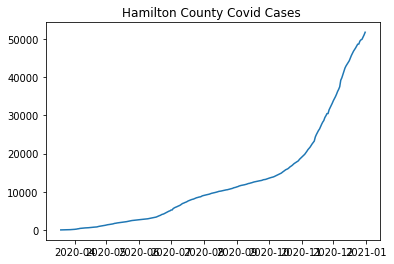

In [1341]:
#Observe same data as Hamilton before, now we need to add Synthetic control data. 
plt.plot(hamilton_data['date'], hamilton_data['cases'])
plt.title("Hamilton County Covid Cases ")
plt.show()

In [1342]:
#Want to construct synthetic control for Hamilton County after Cincinnati NFL game at 10/4

#First, we gain the list of synthetic counties to use 
cincinnati_synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == 'Cincinnati']['Donor_Counties'])[0]
print(sorted(cincinnati_synthetic_counties))

['Ashland', 'Ashtabula', 'Athens', 'Auglaize', 'Belmont', 'Champaign', 'Clinton', 'Columbiana', 'Coshocton', 'Crawford', 'Darke', 'Defiance', 'Fairfield', 'Gallia', 'Guernsey', 'Hardin', 'Harrison', 'Highland', 'Hocking', 'Holmes', 'Huron', 'Lawrence', 'Licking', 'Logan', 'Lucas', 'Meigs', 'Mercer', 'Miami', 'Morgan', 'Morrow', 'Muskingum', 'Noble', 'Ottawa', 'Paulding', 'Perry', 'Pickaway', 'Pike', 'Preble', 'Putnam', 'Richland', 'Ross', 'Sandusky', 'Scioto', 'Seneca', 'Tuscarawas', 'Van Wert', 'Vinton', 'Williams', 'Wood', 'Wyandot']


In [1343]:
#Now, we want to construct a synthetic control with the above counties, using LASSO regression.

#Followed similar steps from above article: https://towardsdatascience.com/causal-inference-with-synthetic-control-in-python-4a79ee636325



#Data doesn't exist for some counties before 3/27, so we'll use data after that
Y = hamilton_data.loc[hamilton_data['date'] < '2020-10-04']
Y = Y.loc[Y['date'] > '2020-03-27']

#X is county covid results for synthetic counties before 2020-10-04
X = county_covid[(county_covid['county'].isin(cincinnati_synthetic_counties)) & (county_covid['date'] < '2020-10-04')]

#Data doesn't exist for some counties before 3/27, so we'll use data after that
X = X.loc[X['date'] > '2020-03-27']

#X = X[['date', 'county', 'cases']]

#We need to create a pivot table with cases, date, and county
X_pivot = X.pivot_table(columns='county', values = 'cases',index = 'date')

Y_pivot = Y.pivot_table(columns='county', values='cases', index='date')

X_pivot.fillna(0, inplace=True)
Y_pivot.fillna(0, inplace=True)


Lasso_weights = Lasso(fit_intercept=False).fit(X_pivot, Y_pivot).coef_

Lasso_weights.round(3)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1447894.5216271959, tolerance: 1056974.333
  positive)


array([ 5.4167e+01,  5.9830e+00, -8.6500e-01,  5.3750e+00,  1.4680e+00,
        5.6600e-01, -4.3720e+00, -3.6300e-01,  8.1680e+00, -2.3710e+00,
       -1.2890e+00, -6.0590e+00,  1.0800e-01,  5.3560e+00,  2.9150e+00,
        8.0400e-01,  1.8300e+00, -1.5429e+01,  3.1730e+00,  1.2970e+00,
       -2.0200e-01, -4.0720e+00,  5.7100e-01, -4.7500e+00,  1.4300e-01,
        1.2531e+01, -8.7000e-02,  3.9000e-02, -2.3260e+00,  7.6300e+00,
       -1.2159e+01,  1.4420e+00,  7.3600e-01,  1.5730e+00, -2.7900e+00,
       -1.1100e-01, -1.2280e+00,  3.6100e+00, -6.0900e-01,  2.7300e-01,
        3.2900e-01, -4.4680e+00,  2.0580e+00, -3.2940e+00,  1.6120e+00,
        1.1974e+01, -2.8839e+01, -9.3020e+00,  2.9750e+00, -3.6020e+00])

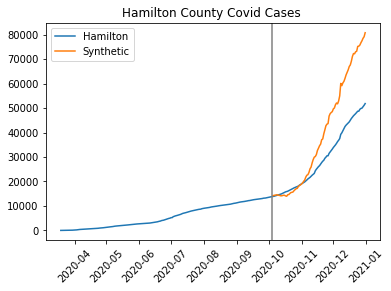

In [1344]:

X_post = county_covid[(county_covid['county'].isin(cincinnati_synthetic_counties)) & (county_covid['date'] > '2020-10-04')]

X_post_pivot = X_post.pivot_table(columns='county', values = 'cases',index = 'date')

Y_post = hamilton_data.loc[hamilton_data['date'] > '2020-10-04']

Y_post_pivot = Y_post.pivot_table(columns='county', values = 'cases',index = 'date')

pca = PCA().fit(X_pivot) #Fit PCA on previous Data
    ####
    
    #print(pca.explained_variance_ratio_)
    
# lm = LinearRegression()
# X_pivot_pca = pca.transform(X_pivot)
    
# pcr = lm.fit(X_pivot_pca, Y_pivot)
    
# pca_post = pca.transform(X_post_pivot)
# prediction = pcr.predict(pca_post)

Hamilton_synthetic = X_post_pivot.dot(Lasso_weights)


#Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 

plt.plot(hamilton_data['date'], hamilton_data['cases'], label='Hamilton')
plt.plot(Hamilton_synthetic, label='Synthetic')
plt.xticks(rotation=45)
plt.title("Hamilton County Covid Cases ")
#plt.tick_params(axis='x', which='major')
plt.xticks()
plt.axvline(x=pd.Timestamp("2020-10-04"), ymin = 0, ymax = 1, color='grey')
#plt.gcf().autofmt_xdate()

plt.legend()
plt.show()
# #X_post_pivot

In [1345]:
#Make earlier process into a function to generalize to other Stadiums

def create_synthetic_graph(team_name_str, stadium_county_str, state_str, intervention_date):
    
    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    stadium_county_str = stadium_county_str[0]
    
    
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    print(team_name_str)
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
    state_str = state_str[0]
    intervention_date = pd.to_datetime(intervention_date)

    stadium_county_data = county_covid.loc[(county_covid['county'] == stadium_county_str) & (county_covid['state'] == state_str)]
    stadium_county_data = stadium_county_data.fillna(0)
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0]

    
    Y = stadium_county_data.loc[stadium_county_data['date'] < intervention_date]
    Y = Y.loc[Y['date'] > '2020-04-01']
    Y['date'] = pd.to_datetime(Y['date'])
    

    #X is county covid results for synthetic counties before 2020-10-04
    X = county_covid.loc[(county_covid['county'].isin(synthetic_counties)) & (county_covid['date'] < intervention_date)]

    #Data doesn't exist for some counties before 3/20, so we'll use data after that
    X = X.loc[X['date'] > '2020-04-01']
    X['date'] = pd.to_datetime(X['date'])


    #We need to create a pivot table with cases, date, and county
    X_pivot = X.pivot_table(columns='county', values = 'cases',index = 'date')
    X_pivot.fillna(0, inplace=True)
    
    Y_pivot = Y.pivot_table(columns='county', values='cases', index='date')

#     Lasso_weights = Lasso(fit_intercept=False, normalize=True, alpha=0.8).fit(X_pivot, Y_pivot).coef_
#     Lasso_weights.round(3)

    X_post = county_covid.loc[(county_covid['county'].isin(synthetic_counties))]
    X_post = X_post.loc[X_post['date'] > '2020-04-01']
    
    X_post_pivot = X_post.pivot_table(columns='county', values = 'cases',index = 'date')
    
    X_post_pivot.fillna(0, inplace=True)

    #USE PCA TO FIND REGRESSION COEFFICIENTS ON X_PIVOT

    pca = PCA(n_components=0.999).fit(X_pivot) #Fit PCA on previous Data
    ####
    
    #print(pca.explained_variance_ratio_)
    
    lm = LinearRegression()
    X_pivot_pca = pca.transform(X_pivot)
    
    pcr = lm.fit(X_pivot_pca, Y_pivot)
    
    pca_post = pca.transform(X_post_pivot)
    prediction = pcr.predict(pca_post)


    #Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 
    fig, ax = plt.subplots()



    sum_cases = stadium_county_data.groupby('date')['cases'].sum()
    
    plt.plot(stadium_county_data['date'], stadium_county_data['cases'], label = stadium_county_str)
    plt.plot(stadium_county_data['date'][-len(prediction):], prediction, label='Synthetic')

    plt.xticks(rotation=45)
    plt.title(team_name_str + " " + stadium_county_str + " County Covid Cases ")

    plt.tick_params(axis='x', which='major')
    plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')
    fig.autofmt_xdate()
    
    ax.legend()
    ax.xaxis_date()
    plt.show()
    
    return 


Denver


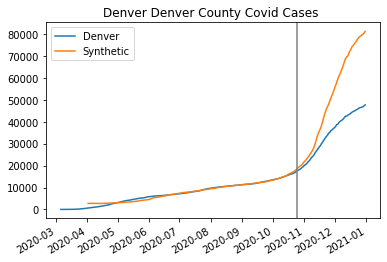

In [1346]:
create_synthetic_graph("Denver",["Denver", "Arapahoe"], ["CO"], ["10/25/2020"])

Arizona


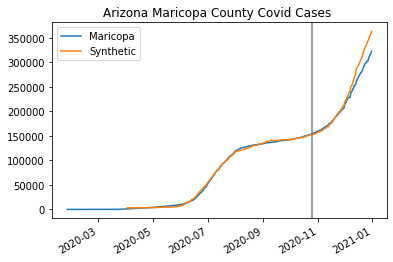

Atlanta


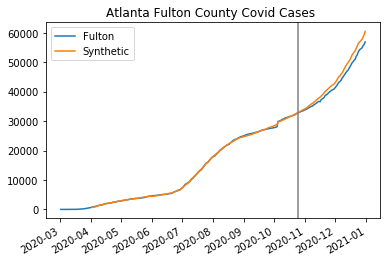

Baltimore


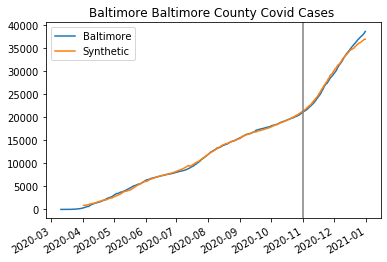

Buffalo


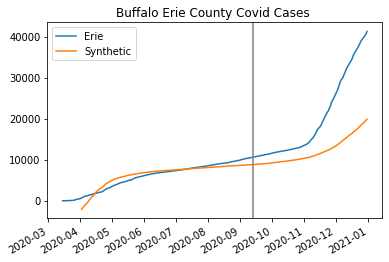

Carolina


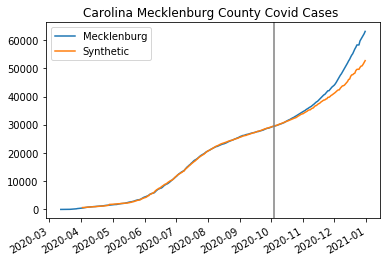

Chicago


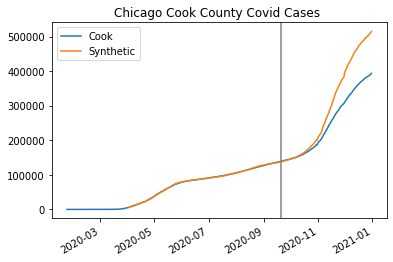

Cincinnati


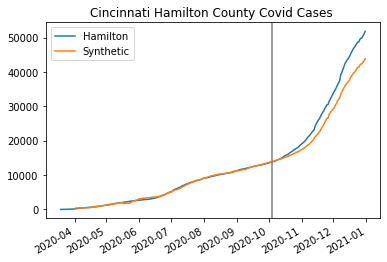

Cleveland


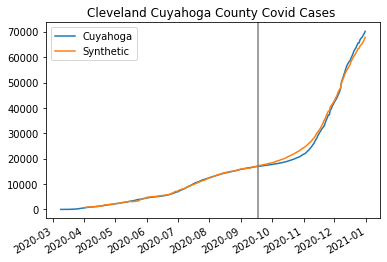

Dallas


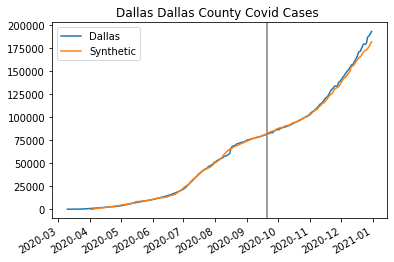

Denver


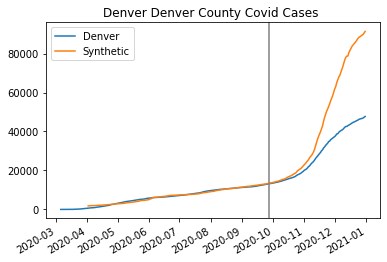

Detroit


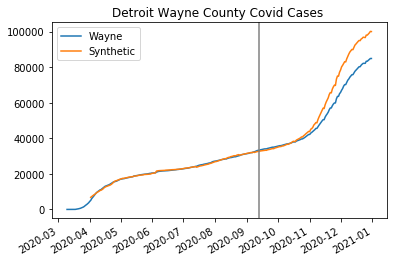

Green Bay


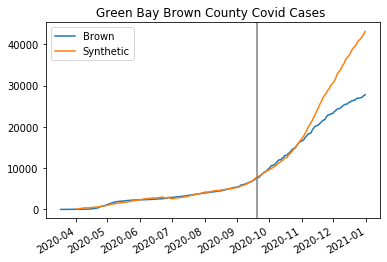

Houston


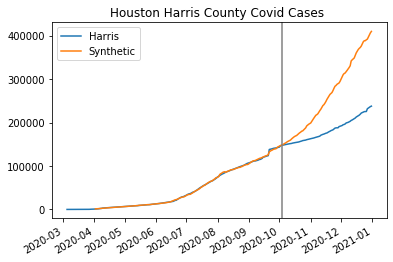

Indianapolis


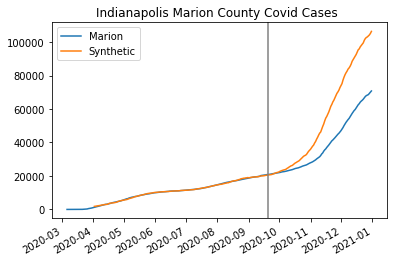

Jacksonville


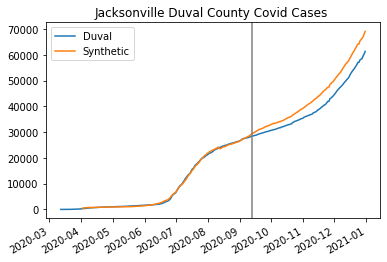

Kansas City


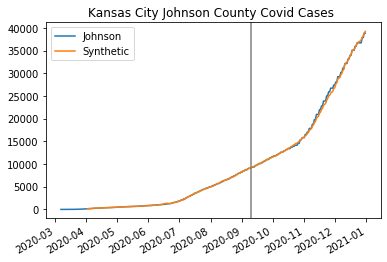

LA Chargers


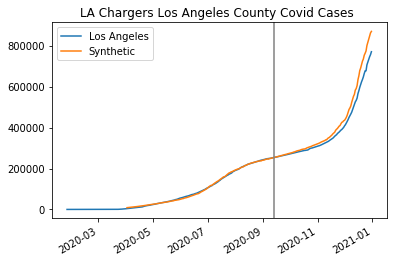

LA Rams


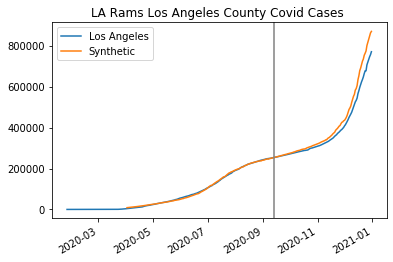

Las Vegas


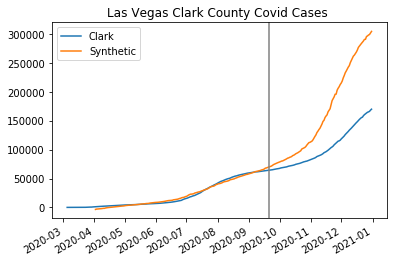

Miami


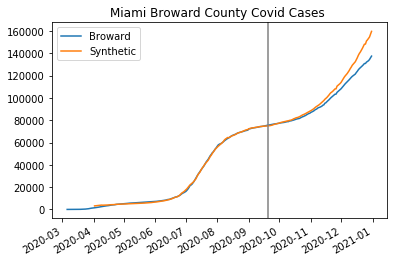

Minnesota


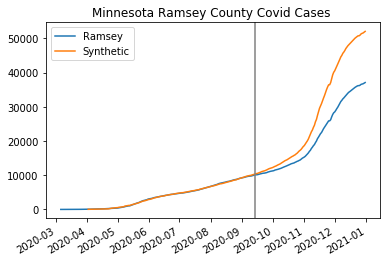

NY Giants


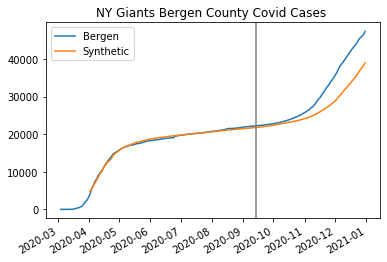

NY Jets


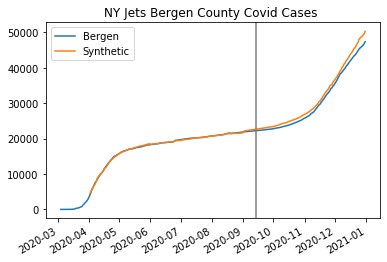

New England


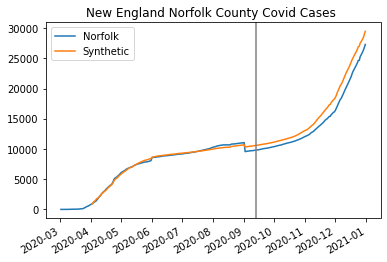

New Orleans


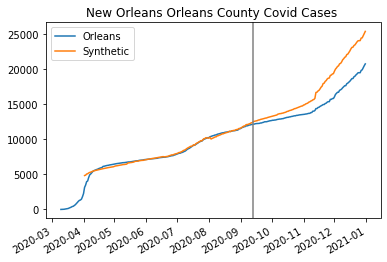

Philadelphia


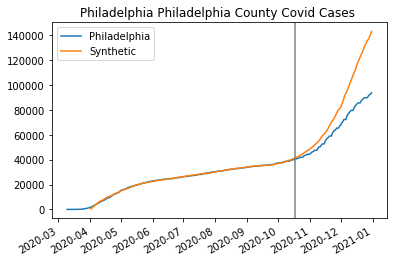

Pittsburgh


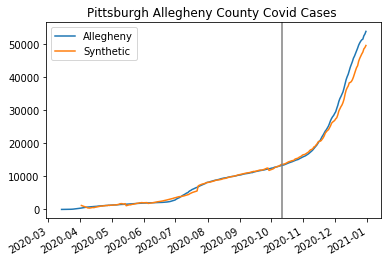

San Francisco


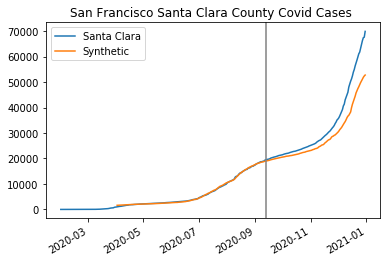

Seattle


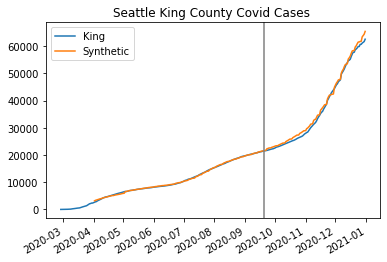

Tampa Bay


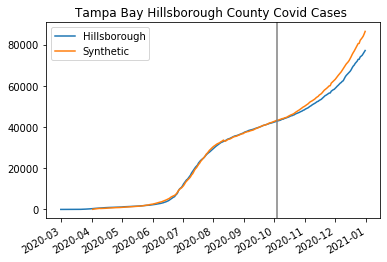

Tennessee


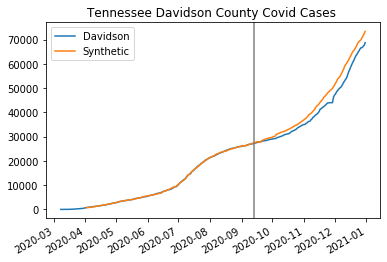

Washington


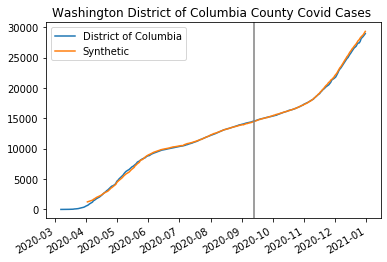

In [1347]:
#Compute graphs for all combinations 

dropped_stadium_df = stadium_county_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)

#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

for i, (team, county, state, date) in enumerate(zipped_input):
    create_synthetic_graph(team, county, state, date)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    


In [1348]:
#Make earlier function to be able to graph weeks 1-6 before the intervention. 

def create_synthetic_lines(team_name_str, stadium_county_str, state_str, intervention_date):
    
    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    stadium_county_str = stadium_county_str[0]
    
    
    
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    print(team_name_str)
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
    state_str = state_str[0]
    intervention_date = pd.to_datetime(intervention_date)
    
    intervention_array = [intervention_date - datetime.timedelta(weeks=i) for i in range(1, 7)]
    count = 0
    for intervention in intervention_array: #Repeat process for 1-6 weeks, 6 separate lines. 
        count += 1
        stadium_county_data = county_covid.loc[(county_covid['county'] == stadium_county_str) & (county_covid['state'] == state_str)]
        stadium_county_data = stadium_county_data.fillna(0)
        stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)

        synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0]


        Y = stadium_county_data.loc[stadium_county_data['date'] < intervention]
        Y = Y.loc[Y['date'] > '2020-04-01']
        Y['date'] = pd.to_datetime(Y['date'])


        #X is county covid results for synthetic counties before 2020-10-04
        X = county_covid.loc[(county_covid['county'].isin(synthetic_counties)) & (county_covid['date'] < intervention)]

        #Data doesn't exist for some counties before 3/20, so we'll use data after that
        X = X.loc[X['date'] > '2020-04-01']
        X['date'] = pd.to_datetime(X['date'])


        #We need to create a pivot table with cases, date, and county
        X_pivot = X.pivot_table(columns='county', values = 'cases',index = 'date')
        X_pivot.fillna(0, inplace=True)

        Y_pivot = Y.pivot_table(columns='county', values='cases', index='date')

    #     Lasso_weights = Lasso(fit_intercept=False, normalize=True, alpha=0.8).fit(X_pivot, Y_pivot).coef_
    #     Lasso_weights.round(3)

        X_post = county_covid.loc[(county_covid['county'].isin(synthetic_counties)) & (county_covid['county'].isin(X_pivot.columns.tolist()))]
        X_post = X_post.loc[X_post['date'] > '2020-04-01']
        
        X_post_pivot = X_post.pivot_table(columns='county', values = 'cases',index = 'date')

        X_post_pivot.fillna(0, inplace=True)

        #USE PCA TO FIND REGRESSION COEFFICIENTS ON X_PIVOT

        pca = PCA(n_components=0.999).fit(X_pivot) #Fit PCA on previous Data
        ####

        #print(pca.explained_variance_ratio_)

        lm = LinearRegression()
        X_pivot_pca = pca.transform(X_pivot)

        pcr = lm.fit(X_pivot_pca, Y_pivot)

        pca_post = pca.transform(X_post_pivot)
        prediction = pcr.predict(pca_post)


    #Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 

    #sum_cases = stadium_county_data.groupby('date')['cases'].sum()
        #Additional line for Synthetic 
        plt.plot(stadium_county_data['date'][-len(prediction):], prediction, label='Synthetic' + 'Week -' + str(count), color = 'grey')

    
    
    #First line for Base county line
    plt.plot(stadium_county_data['date'], stadium_county_data['cases'], label = stadium_county_str)
    

    plt.xticks(rotation=45)
    plt.title(team_name_str + " " + stadium_county_str + " County Covid Cases ")

    plt.tick_params(axis='x', which='major')
    #plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')
    fig.autofmt_xdate()
    
    plt.legend()
    plt.show()
    
    return 


Kansas City


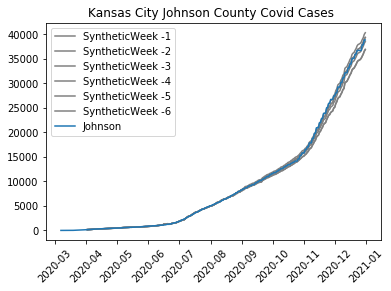

In [1349]:
create_synthetic_lines("Kansas City",['Johnson', 'Jackson', '', '', '', '', '', ''], ['KS', 'MO', '', '', '', '', '', ''], ["09/21/2020"])

Arizona


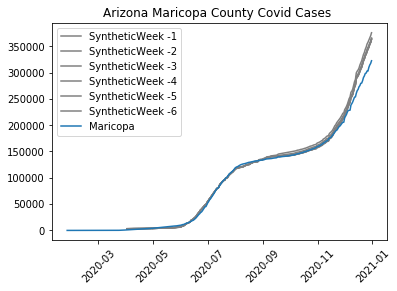

Atlanta


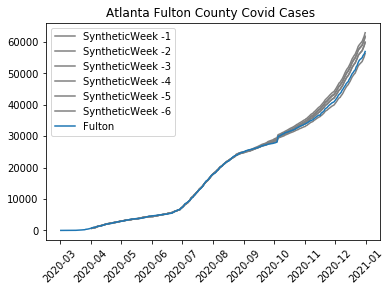

Baltimore


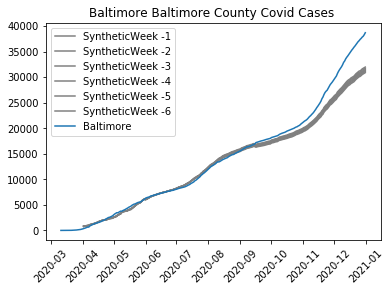

Buffalo


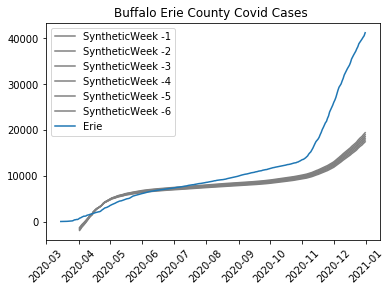

Carolina


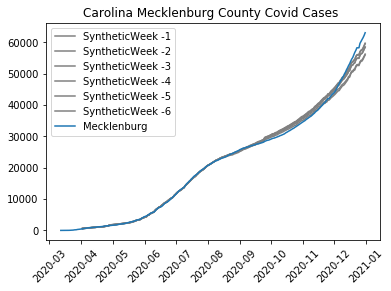

Chicago


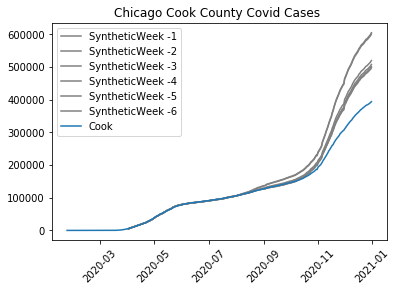

Cincinnati


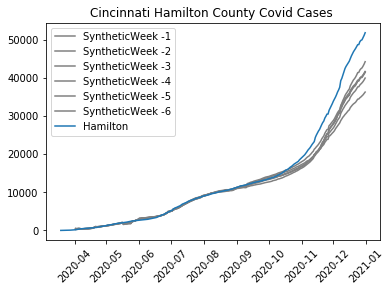

Cleveland


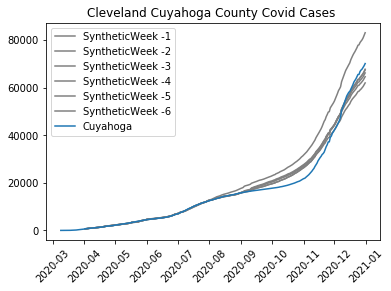

Dallas


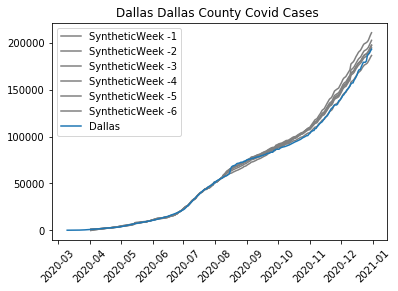

Denver


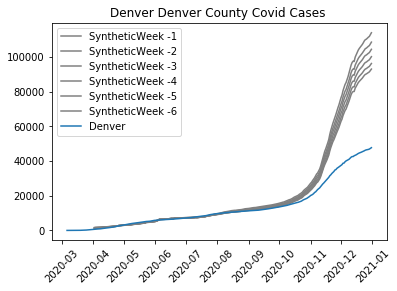

Detroit


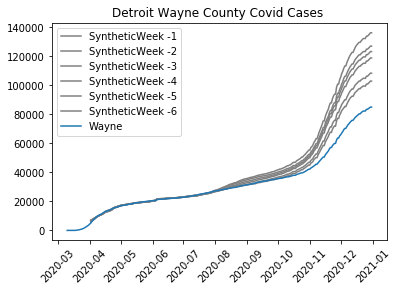

Green Bay


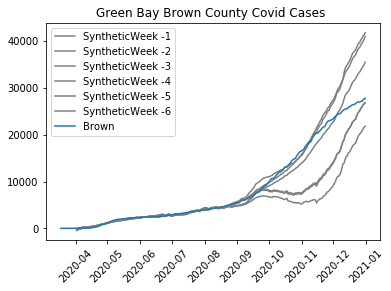

Houston


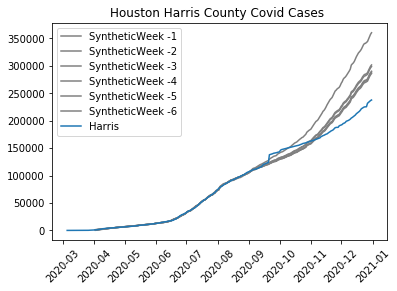

Indianapolis


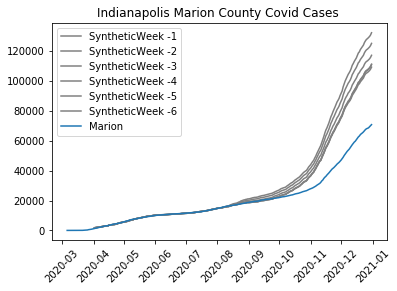

Jacksonville


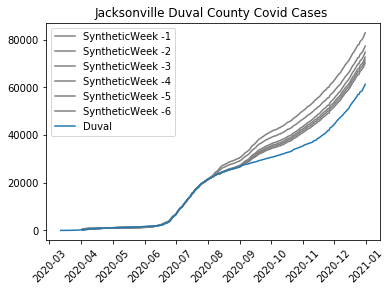

Kansas City


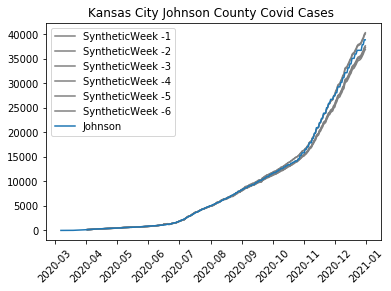

LA Chargers


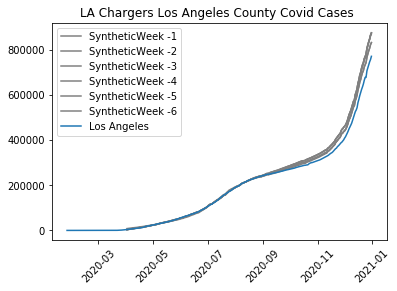

LA Rams


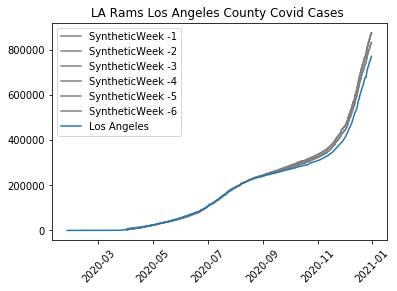

Las Vegas


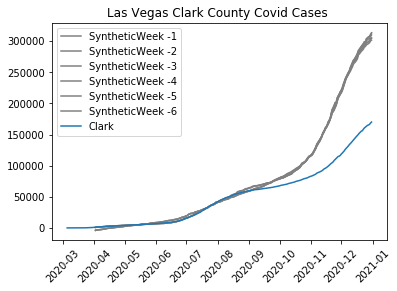

Miami


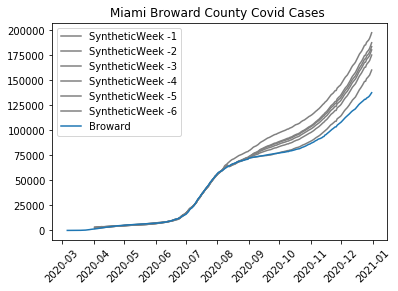

Minnesota


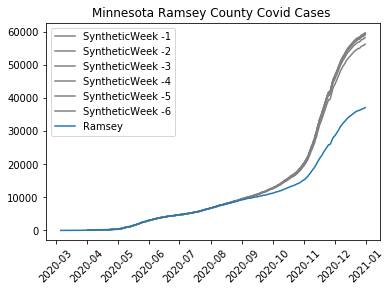

NY Giants


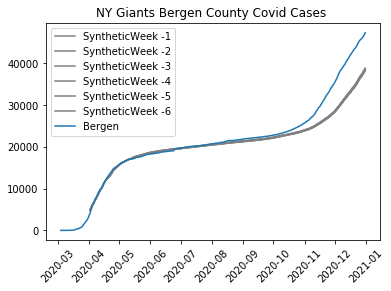

NY Jets


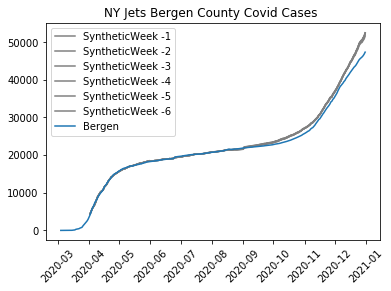

New England


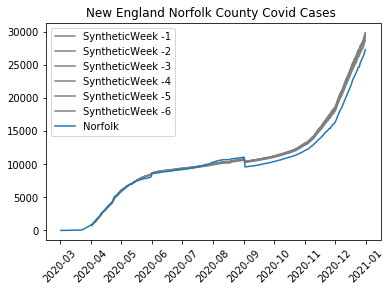

New Orleans


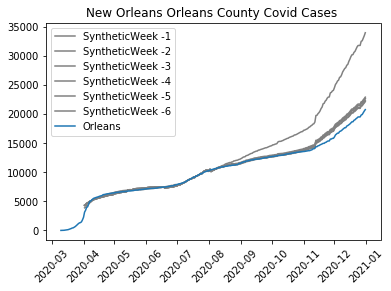

Philadelphia


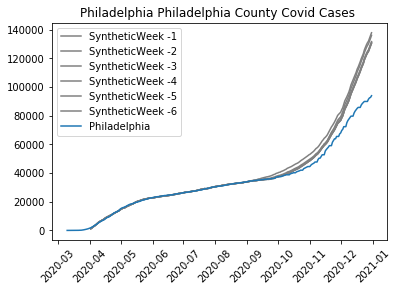

Pittsburgh


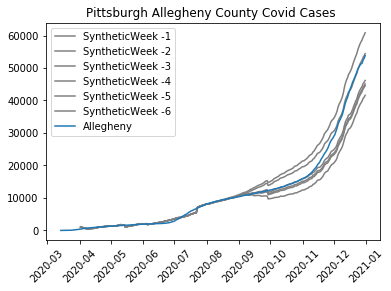

San Francisco


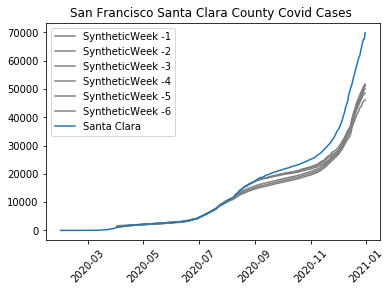

Seattle


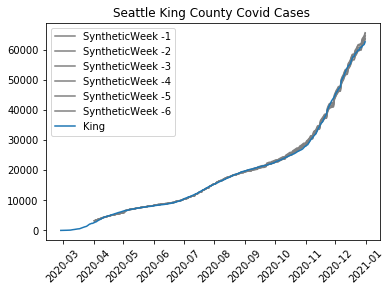

Tampa Bay


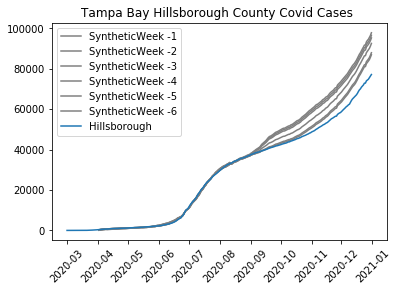

Tennessee


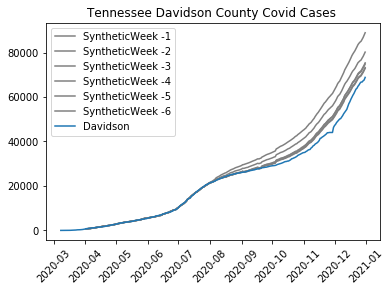

Washington


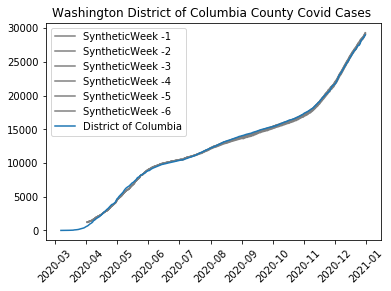

In [1350]:
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])
for i, (team, county, state, date) in enumerate(zipped_input):
    try:
        create_synthetic_lines(team, county, state, date)
    except:
        print(team)
        print(county)
        print(state)